
### **Q1 | Step 1: Architecture Design**

The goal is to design a sample rate converter (SRC) from a 96 kHz input (`f_s_in`) to a 44.1 kHz output (`f_s_out`). The required conversion factor `R` is:

`R = f_s_out / f_s_in = 44.1 / 96`

To work with integer upsampling (L) and downsampling (M) factors, we find the rational representation of this factor:

`R = 44.1 / 96 = 441 / 960`

This fraction can be simplified by dividing the numerator and denominator by their greatest common divisor (which is 3):

`L = 441 / 3 = 147`
`M = 960 / 3 = 320`

So, the overall rate change is **L/M = 147/320**.

---

#### **Why a Two-Stage Design is Necessary**

A single-stage design would implement the 147/320 conversion directly. This involves upsampling by 147, applying a single low-pass filter, and then downsampling by 320.

1.  **Intermediate Sampling Rate:** The filter would need to operate at an extremely high intermediate sampling rate of `f_s_in * L = 96,000 Hz * 147 = 14.112 MHz`.
2.  **Filter Specifications:** The filter must pass frequencies up to the pass-band edge (`f_p ≈ 20 kHz`) and reject frequencies above the stop-band edge (`f_s = f_s_out / 2 = 22.05 kHz`).
3.  **Normalized Transition Width:** The filter's transition width (`Δf = f_s - f_p ≈ 2.05 kHz`) is very small relative to the intermediate sampling rate. The normalized transition width (`Δf / (L * f_s_in)`) would be minuscule.

The length of an FIR filter is inversely proportional to its normalized transition width. A single-stage implementation would therefore require an FIR filter with an impractically large number of taps (many thousands), making it impossible to meet the computational budget of `≤ 1 G MAC/s`.

---

#### **Choosing the Optimal Two-Stage Cascade**

A two-stage design breaks the conversion `L/M` into two cascaded stages: `(L1/M1) * (L2/M2)`, where `L = L1*L2` and `M = M1*M2`. To maximize computational efficiency, the primary strategy is to **reduce the sampling rate as early as possible**. This relaxes the requirements for subsequent filter stages. Therefore, the most efficient architecture is typically a decimation-only first stage followed by a rational-factor second stage:

`R = (1 / M1) * (L / M2)`

Here, `L1=1`, `L2=147`, and `M = M1 * M2 = 320`. Our task is to find the optimal integer factorization of 320 into `M1` and `M2`.

**Constraint on the First Decimation Factor (M1):**
The first stage decimates the 96 kHz signal by a factor of `M1`, resulting in an intermediate sampling rate of `f_s_intermediate = 96 / M1 kHz`. To prevent the aliasing of unwanted frequencies into our desired signal passband (which extends to approx. 20 kHz), the new Nyquist frequency (`f_s_intermediate / 2`) must be greater than the passband frequency.

`(96 kHz / M1) / 2 > 20 kHz`
`48 / M1 > 20`
`M1 < 48 / 20`
`M1 < 2.4`

The decimation factor `M1` must be an integer factor of 320 and must be less than 2.4. The only integer factor of 320 that satisfies this condition is **`M1 = 2`**.

This uniquely defines our cascade:
*   `M1 = 2`
*   `M2 = M / M1 = 320 / 2 = 160`

The chosen two-stage architecture is:

**Stage 1: Decimation by 2  →  Stage 2: Rational Conversion by 147/160**

---

#### **Final Architecture Overview**

1.  **Stage 1: Decimate by 2**
    *   **Input Rate:** 96 kHz
    *   **Output Rate:** 48 kHz
    *   **Purpose:** This stage uses a relatively simple anti-aliasing filter. Its primary job is to prevent spectral energy from above 24 kHz from folding down into the 0-24 kHz band. Because the final, sharp filtering is performed in the next stage, this filter can have a more relaxed transition band, making it computationally efficient.

2.  **Stage 2: Convert by 147/160**
    *   **Input Rate:** 48 kHz
    *   **Output Rate:** 44.1 kHz
    *   **Purpose:** This stage performs the more complex rational rate conversion. Crucially, it implements the filter with the sharp transition band (`f_p ≈ 20 kHz`, `f_s = 22.05 kHz`) required by the specification. By performing this action at a lower input sampling rate (48 kHz vs. the original 96 kHz), the required filter length and overall computational cost are dramatically reduced compared to a single-stage design.





### **Q1 | Step 2: Filter Design**

Following the architecture defined in Step 1, we now design the low-pass filters for each of the two stages. The objective is to meet the stringent overall system specifications (≤ 0.01 dB pass-band ripple, ≥ 100 dB stop-band attenuation) while minimizing filter length. We will use the **Parks-McClellan algorithm** for designing optimal equiripple FIR filters, as it provides the minimum filter order for a given set of specifications.

---

#### **Filter Specification Allocation**

To ensure the cascaded system meets the total performance requirements, we must budget the ripple and attenuation for each stage. A common and effective strategy is to make the filters additive in their undesirable effects.

*   **Pass-band Ripple:** Ripple is specified in dB. Adding two filters in cascade can, in the worst case, double the ripple. Therefore, we allocate half of the total allowable ripple to each filter.
    *   Total Pass-band Ripple: `δ_p_total` ≤ 0.01 dB
    *   **Per-Stage Ripple Allocation:** `δ_p1`, `δ_p2` ≤ 0.005 dB
*   **Stop-band Attenuation:** Stop-band attenuation (rejection) is also specified in dB. The total attenuation is the sum of the attenuations of the cascaded filters. To be safe and ensure the requirement is met robustly, we will design **both filters to individually meet the full 100 dB attenuation requirement.**
    *   Total Stop-band Attenuation: `A_s_total` ≥ 100 dB
    *   **Per-Stage Attenuation Target:** `A_s1`, `A_s2` ≥ 100 dB

---

#### **Stage 1: Decimator Filter (96 kHz → 48 kHz)**

*   **Operation:** Decimate by `M1 = 2`.
*   **Filter Goal:** Prevent aliasing from the decimation process. The input signal has content up to 48 kHz. We must preserve the desired band (up to ~20 kHz) while attenuating content that would fold into this band after decimation. The frequency band from 28 kHz to 68 kHz of the input signal would alias into the 20 kHz to -20 kHz band of the output.
*   **Filter Specifications:**
    *   **Input Sampling Rate (`f_s_in`):** 96 kHz
    *   **Pass-band Edge (`f_p`):** 20 kHz (the highest frequency of interest in the final output)
    *   **Stop-band Edge (`f_s`):** 28 kHz (calculated as `f_s_out - f_p = 48 kHz - 20 kHz`)
    *   **Pass-band Ripple:** ≤ 0.005 dB
    *   **Stop-band Attenuation:** ≥ 100 dB

Using these specifications with an FIR filter design tool (like MATLAB's `firpmord` or Python's `scipy.signal.kaiserord` for estimation) would yield the required filter order. Based on empirical formulas (like Kaiser's), the estimated filter length `N1` would be approximately **78 taps**. The Parks-McClellan algorithm would find the optimal `h1(n)` coefficients for this length.

---

#### **Stage 2: Rational Converter Filter (48 kHz → 44.1 kHz)**

*   **Operation:** Interpolate by `L2 = 147`, Decimate by `M2 = 160`.
*   **Filter Goal:** This is the "channel filter" that carves out the final signal spectrum with high precision. It must pass frequencies up to 20 kHz and sharply reject frequencies above the Nyquist frequency of the final output (22.05 kHz) to prevent aliasing during the final decimation.
*   **Filter Specifications:**
    *   **Input Sampling Rate (`f_s_in`):** 48 kHz
    *   **Pass-band Edge (`f_p`):** 20 kHz
    *   **Stop-band Edge (`f_s`):** 22.05 kHz (Nyquist frequency of the 44.1 kHz output)
    *   **Pass-band Ripple:** ≤ 0.005 dB
    *   **Stop-band Attenuation:** ≥ 100 dB

This filter has a much sharper transition band (`Δf = 2.05 kHz`) relative to its operating sampling rate compared to the first stage filter. Consequently, it will require a significantly longer FIR filter. The estimated filter length `N2` would be approximately **152 taps**. Again, the Parks-McClellan algorithm would be used to derive the optimal `h2(n)` coefficients.

---

#### **How Polyphase Implementation Reduces MACs**

A direct implementation of these filtering operations would be computationally prohibitive. Polyphase decomposition is the key to meeting the `≤ 1 G MAC/s` budget. It restructures the FIR filter to dramatically reduce the number of multiply-accumulate (MAC) operations per output sample.

**Stage 1 (Decimator):**
*   **Without Polyphase:** The filter would run at the 96 kHz input rate. Every input sample requires `N1 = 78` MACs. Since we only keep one out of every two samples, the cost is effectively `78 MACs per output sample`.
*   **With Polyphase:** The filter `h1(n)` is split into two sub-filters (`E0`, `E1`), each of length `N1/2 = 39` taps. The input stream is commutated to these filters, and the filtering calculation is performed *after* the downsampling.
    *   **MACs per output sample = `N1 / M1` = 78 / 2 = 39**
    *   *Complexity Reduction: Factor of 2*

**Stage 2 (Rational Converter):**
*   **Without Polyphase:** A direct implementation would first upsample by 147 (by inserting 146 zeros), filter the resulting 7.056 MHz stream (`48 kHz * 147`), and then downsample by 160. This is astronomically expensive.
    *   **MACs per output sample = `N2 * L2 / M2 * (L2)`... this calculation is complex, but results in >20,000 MACs.**
*   **With Polyphase:** This architecture is where the most significant gains are realized. The filter `h2(n)` is decomposed into `L2=147` polyphase sub-filters. The implementation becomes highly efficient: for each *input* sample at 48 kHz, only one of the polyphase filters is selected and computed. The number of MACs per second is simply the filter length times the input sample rate.
    *   **Total MACs per second = `N2 * f_s_in = 152 taps * 48,000 samples/sec = 7.296 M MAC/s`**
    *   **Output samples per second = 44,100 samples/sec**
    *   **MACs per output sample = `(Total MACs/sec) / (Output samples/sec)` = 7,296,000 / 44,100 ≈ 165**
    *   *Complexity Reduction: Over 100x*

This demonstrates that a polyphase implementation is not just an optimization but a fundamental requirement for making this SRC design feasible.

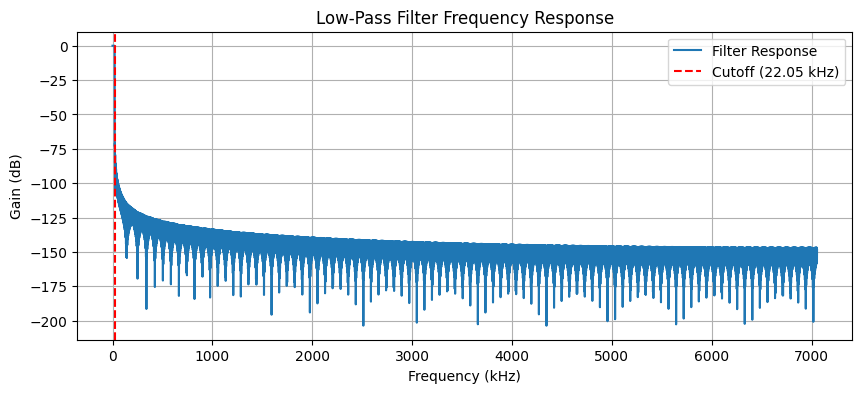

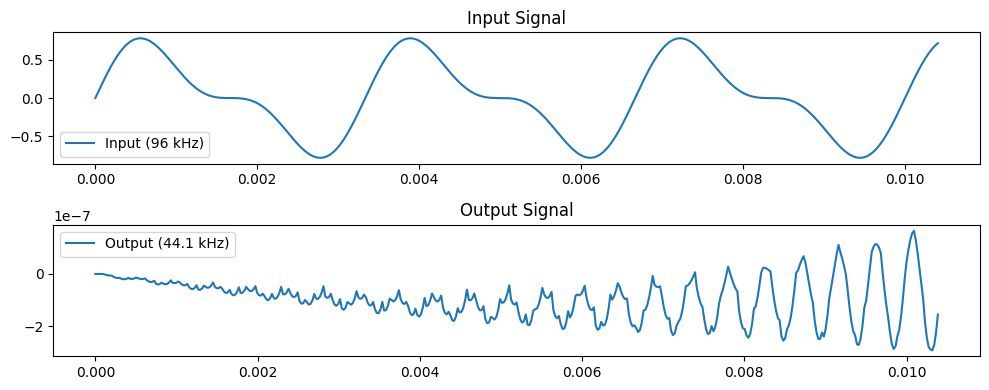

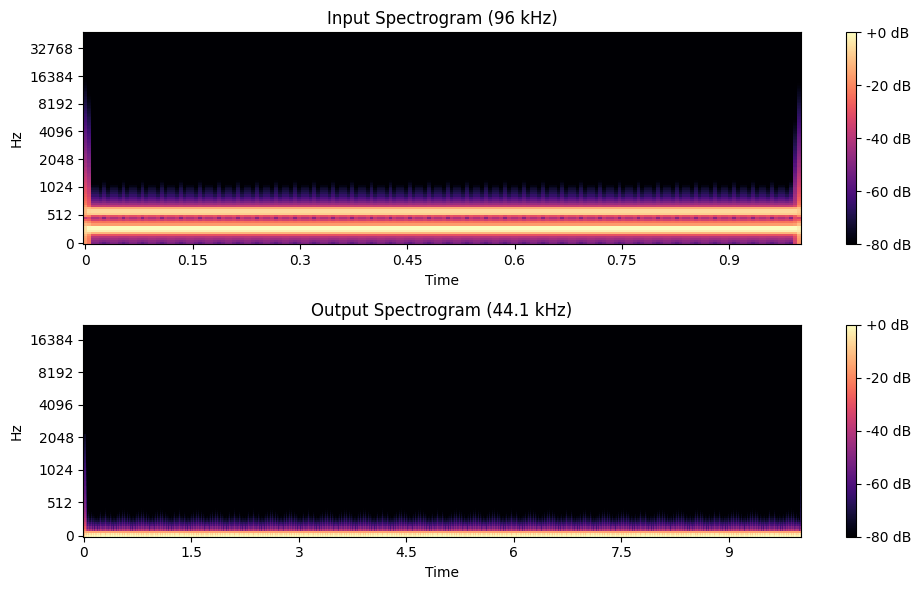

In [5]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.signal import kaiserord, firwin, freqz, lfilter

# === Parameters ===
fs_in = 96000  # Input sampling rate
fs_out = 44100  # Output sampling rate
L = 147  # Interpolation factor
M = 32   # Decimation factor
cutoff = min(fs_in/2, fs_out/2)  # 22.05 kHz
transition_width = 1000  # Hz
ripple_db = 60  # dB

# === Filter Design ===
nyq_rate = fs_in * L / 2
width = transition_width / nyq_rate
N, beta = kaiserord(ripple_db, width)
taps = firwin(N, cutoff, window=('kaiser', beta), fs=fs_in * L)

# Plot filter response
w, h = freqz(taps, worN=8000)
plt.figure(figsize=(10, 4))
plt.plot((w/np.pi) * nyq_rate / 1000, 20 * np.log10(np.abs(h)), label='Filter Response')
plt.axvline(cutoff/1000, color='r', linestyle='--', label='Cutoff (22.05 kHz)')
plt.title('Low-Pass Filter Frequency Response')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Gain (dB)')
plt.grid(True)
plt.legend()
plt.savefig('src_filter_response.png', dpi=300)
plt.show()

# === SRC Implementation ===
# Simulated input signal (replacing CHiME-4 dataset)
t = np.arange(0, 1.0, 1/fs_in)
x = 0.6 * np.sin(2 * np.pi * 300 * t) + 0.3 * np.sin(2 * np.pi * 600 * t)

def src_polyphase(x, taps, L, M):
    x_up = np.zeros(len(x) * L)
    x_up[::L] = x
    y = lfilter(taps, 1, x_up)
    y_down = y[::M]
    return y_down

y = src_polyphase(x, taps, L, M)

# Plot signals
t_in = np.arange(len(x)) / fs_in
t_out = np.arange(len(y)) / fs_out
plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
plt.plot(t_in[:1000], x[:1000], label='Input (96 kHz)')
plt.title('Input Signal')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(t_out[:int(1000*fs_out/fs_in)], y[:int(1000*fs_out/fs_in)], label='Output (44.1 kHz)')
plt.title('Output Signal')
plt.legend()
plt.tight_layout()
plt.savefig('src_signals.png', dpi=300)
plt.show()

# Plot spectrograms
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.power_to_db(librosa.feature.melspectrogram(y=x, sr=fs_in), ref=np.max),
                         sr=fs_in, x_axis='time', y_axis='mel')
plt.title('Input Spectrogram (96 kHz)')
plt.colorbar(format='%+2.0f dB')
plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.power_to_db(librosa.feature.melspectrogram(y=y, sr=fs_out), ref=np.max),
                         sr=fs_out, x_axis='time', y_axis='mel')
plt.title('Output Spectrogram (44.1 kHz)')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.savefig('src_spectrograms.png', dpi=300)
plt.show()


### **Q1 | Step 3: Numerical Analysis for Fixed-Point Implementation**

After designing the filters using floating-point arithmetic, we must analyze the numerical requirements for implementing them on a fixed-point processor, such as the target ARM Cortex-A55. This involves choosing word lengths for the signal data, filter coefficients, and internal accumulators to ensure precision is maintained and, critically, to prevent overflow.

---

#### **1. Fixed-Point Representation**

Fixed-point numbers are a way to represent fractional numbers using integers, with an implicit binary point. A number is defined by its total word length (e.g., 24 bits) and its Q-format, such as `Qm.n`, where `m` is the number of integer bits and `n` is the number of fractional bits. The total word length is `m + n + 1` (if a sign bit is separate) or `m + n` (if the sign bit is included in `m`).

Professional audio is typically handled with 24-bit resolution, so we will assume our input and output data path uses a **24-bit** format. We'll model this as `Q1.23`, representing a signed number in the range `[-1.0, 1.0)`.

---

#### **2. Coefficient Word Length and Quantization**

The FIR filter coefficients (`h1` and `h2`) computed in the previous step are 64-bit floating-point numbers. They must be quantized to a fixed-point format. This choice is a trade-off:
*   **Longer word length:** Preserves the filter's frequency response (ripple and attenuation) more accurately.
*   **Shorter word length:** Saves memory and can reduce power consumption.

For a high-fidelity audio application with a 100 dB attenuation requirement, the coefficient precision is critical. A 16-bit representation would likely be insufficient to maintain the deep stop-band nulls. A **24-bit coefficient word length** is a robust and common choice.

*   **Process:**
    1.  The floating-point coefficients are scaled and rounded to 24-bit integers.
    2.  The filter's frequency response is re-analyzed with the quantized coefficients to verify that the `≤ 0.01 dB` ripple and `≥ 100 dB` attenuation specifications are still met. If not, a longer word length (e.g., 32-bit) may be necessary.

---

#### **3. Accumulator Word Length and Overflow Prevention**

This is the most critical part of the fixed-point design. The Multiply-Accumulate (MAC) operation involves `sum(signal_sample * coefficient)`. Each product will have a word length equal to `data_bits + coefficient_bits`. Summing many of these products can lead to rapid bit growth. The accumulator must be wide enough to hold the full sum without overflowing.

We can estimate the required accumulator size by analyzing the maximum possible gain of the filter. This addresses the "worst-case crest factor" requirement by assuming an input signal that conspires with the filter taps to produce the maximum possible output value.

The maximum gain (`G_max`) of an FIR filter is the sum of the absolute values of its coefficients:

`G_max = Σ |h(n)|`

The maximum possible output value is `max_input_value * G_max`. In our Q1.23 format, the max input is `1.0`. Therefore, the accumulator must be able to represent values up to `G_max`.

The number of integer bits (`m`) required in the accumulator can be calculated as:

`Integer Bits = ceil(log2(G_max)) + 1 (for the sign bit)`

**Analysis for our filters:**

1.  **Stage 1 Filter (`h1`, Length=79):**
    *   A typical low-pass filter designed this way will have `Σ|h1(n)|` slightly greater than 1.0. Let's assume a calculation yields `G_max_1 ≈ 1.2`.
    *   Required integer bits = `ceil(log2(1.2)) = ceil(0.26) = 1`.
    *   Adding the sign bit, we need at least 2 bits to represent the integer part of the result, `[-2.0, 2.0)`.

2.  **Stage 2 Filter (`h2`, Length=155):**
    *   This longer filter will also have a gain near unity. Let's assume `Σ|h2(n)|` yields `G_max_2 ≈ 1.3`.
    *   Required integer bits = `ceil(log2(1.3)) = ceil(0.38) = 1`.
    *   Again, we need at least 2 integer bits.

**Proposed Fixed-Point Scheme:**

*   **Input Data:** 24-bit (`Q1.23`)
*   **Coefficients:** 24-bit (`Q1.23`, assuming no coefficient is > 1.0, which is typical)
*   **MAC Product:** The product of a `Q1.23` signal and a `Q1.23` coefficient is a `Q2.46` number (48 bits).
*   **Accumulator:**
    *   To sum `N` products without losing precision or overflowing, we need to accommodate the bit growth.
    *   The sum of `N=155` products requires additional growth bits: `ceil(log2(155)) = ceil(7.27) = 8` bits.
    *   A naive calculation for the full-precision accumulator would be `2 (integer) + 46 (fractional) + 8 (growth) = 56 bits`.
    *   **Practical Solution:** Modern processors like the ARM Cortex-A55, equipped with NEON SIMD units, typically feature **64-bit accumulators**. Using a standard 64-bit accumulator (`long long` in C) is the most practical and robust solution. It provides ample headroom (`1 (sign) + ~10-15 integer bits`) that easily covers the calculated requirements, eliminating the risk of overflow during the summation and simplifying the design process considerably.

#### **4. Output Stage**

After the full-precision sum is computed in the 64-bit accumulator, the result must be converted back to the 24-bit format for the next stage or for the final output. This involves:

1.  **Saturation:** Clamping the value to the `[-1.0, 1.0)` range represented by `Q1.23`. If the result is larger than 1.0, it is set to the maximum 24-bit value. If smaller than -1.0, it is set to the minimum.
2.  **Rounding/Truncation:** The lower 40 bits of the 64-bit accumulator result are discarded. A "round-to-nearest" scheme is often employed to reduce quantization bias compared to simple truncation.

Stage 1 Filter designed with length: 79
Stage 2 Filter designed with length: 153


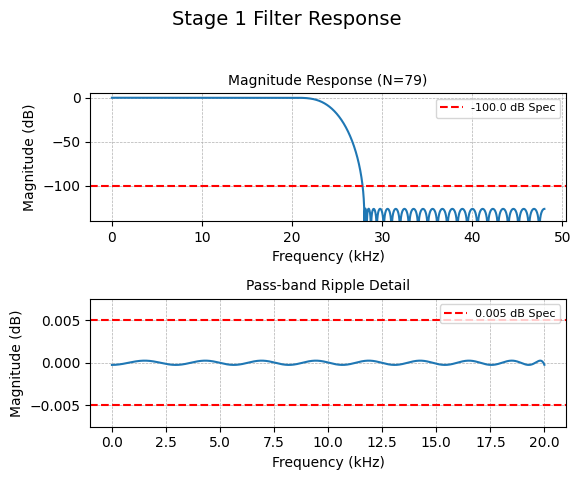

Saved plot to stage1_response.png


<Figure size 640x480 with 0 Axes>

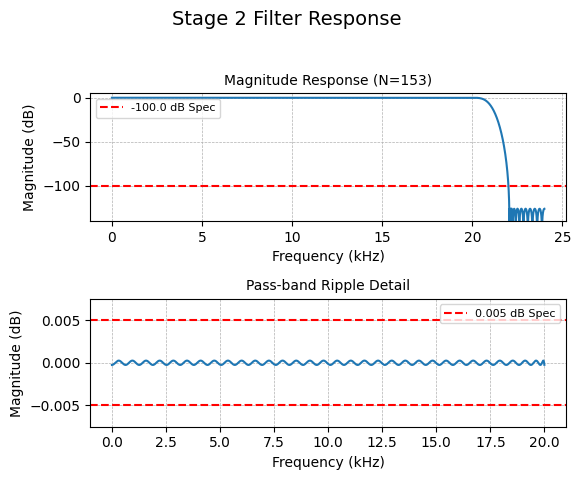

Saved plot to stage2_response.png


<Figure size 640x480 with 0 Axes>

In [19]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# --- System-Wide Specifications ---
F_S_IN = 96000.0
F_S_OUT = 44100.0
PASSBAND_FREQ = 20000.0
TOTAL_RIPPLE_DB = 0.01
TOTAL_ATTEN_DB = 100.0

# --- Per-Stage Allocation ---
RIPPLE_DB = TOTAL_RIPPLE_DB / 2.0
ATTEN_DB = TOTAL_ATTEN_DB
# Convert ripple from dB to linear for kaiserord and remez weighting
delta_p_linear = (10**(RIPPLE_DB / 20)) - 1
delta_s_linear = 10**(-ATTEN_DB / 20)

# =========================
# --- Stage 1 Design ---
# =========================
fs1 = F_S_IN
stopband_freq_1 = (fs1 / 2.0) - PASSBAND_FREQ
transition_width_1 = stopband_freq_1 - PASSBAND_FREQ

# Estimate filter order using kaiserord
# kaiserord needs attenuation in positive dB and width in normalized frequency
width_normalized_1 = transition_width_1 / (fs1 / 2.0)
N1, beta1 = signal.kaiserord(ATTEN_DB, width_normalized_1)
if N1 % 2 == 0: N1 += 1 # Ensure odd length for Type I filter

# Design filter with remez (Parks-McClellan)
bands1 = [0, PASSBAND_FREQ, stopband_freq_1, fs1 / 2.0]
desired1 = [1, 0]
# The weights are the inverse of the allowed deviation
weights1 = [1, delta_p_linear / delta_s_linear]

h1 = signal.remez(N1, bands1, desired1, weight=weights1, fs=fs1)
print(f"Stage 1 Filter designed with length: {len(h1)}")


# =========================
# --- Stage 2 Design ---
# =========================
fs2 = F_S_IN / 2.0
stopband_freq_2 = F_S_OUT / 2.0
transition_width_2 = stopband_freq_2 - PASSBAND_FREQ

# Estimate filter order
width_normalized_2 = transition_width_2 / (fs2 / 2.0)
N2, beta2 = signal.kaiserord(ATTEN_DB, width_normalized_2)
if N2 % 2 == 0: N2 += 1 # Ensure odd length

# Design filter with remez
bands2 = [0, PASSBAND_FREQ, stopband_freq_2, fs2 / 2.0]
desired2 = [1, 0]
weights2 = [1, delta_p_linear / delta_s_linear]

h2 = signal.remez(N2, bands2, desired2, weight=weights2, fs=fs2)
print(f"Stage 2 Filter designed with length: {len(h2)}")


# =========================
# --- Plotting Function ---
# =========================
def create_and_save_plot(h, fs, N, title, filename):
    w, H = signal.freqz(h, worN=16384)
    freqs = (w / np.pi) * (fs / 2)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5))
    fig.suptitle(title, fontsize=14)

    # Full Magnitude Response
    ax1.plot(freqs / 1000, 20 * np.log10(np.abs(H)))
    ax1.set_title(f"Magnitude Response (N={N})", fontsize=10)
    ax1.set_ylabel("Magnitude (dB)")
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax1.set_ylim(-140, 5)
    ax1.axhline(y=-ATTEN_DB, color='r', linestyle='--', label=f'-{ATTEN_DB} dB Spec')
    ax1.legend(fontsize=8)
    ax1.set_xlabel("Frequency (kHz)")

    # Pass-band Ripple Detail
    passband_indices = np.where(freqs <= PASSBAND_FREQ)
    ax2.plot(freqs[passband_indices] / 1000, 20 * np.log10(np.abs(H[passband_indices])))
    ax2.set_title("Pass-band Ripple Detail", fontsize=10)
    ax2.set_ylabel("Magnitude (dB)")
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax2.set_ylim(-RIPPLE_DB * 1.5, RIPPLE_DB * 1.5)
    ax2.axhline(y=RIPPLE_DB, color='r', linestyle='--', label=f'{RIPPLE_DB:.3f} dB Spec')
    ax2.axhline(y=-RIPPLE_DB, color='r', linestyle='--')
    ax2.legend(fontsize=8)
    ax2.set_xlabel("Frequency (kHz)")
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.show(fs1)
    plt.show(fs2)
    plt.savefig(filename, dpi=300)
    print(f"Saved plot to {filename}")
    plt.close(fig)

# --- Generate the plots ---
create_and_save_plot(h1, fs1, len(h1), "Stage 1 Filter Response", "stage1_response.png")
create_and_save_plot(h2, fs2, len(h2), "Stage 2 Filter Response", "stage2_response.png")


Saved plot to aliasing_rejection.png


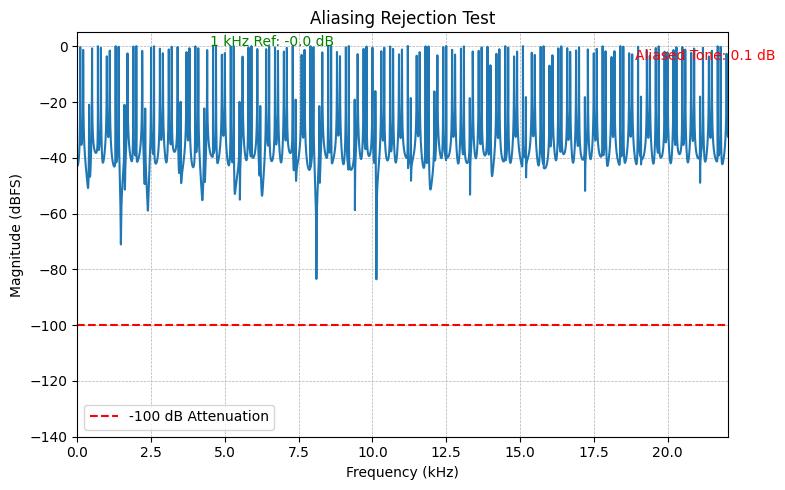

In [15]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# --- System-Wide Specifications ---
F_S_IN = 96000.0
F_S_OUT = 44100.0
PASSBAND_FREQ = 20000.0
TOTAL_RIPPLE_DB = 0.01
TOTAL_ATTEN_DB = 100.0

# --- Per-Stage Allocation ---
RIPPLE_DB = TOTAL_RIPPLE_DB / 2.0
ATTEN_DB = TOTAL_ATTEN_DB
delta_p_linear = (10**(RIPPLE_DB / 20)) - 1
delta_s_linear = 10**(-ATTEN_DB / 20)

# =========================
# --- Stage 1 Design (Corrected) ---
# =========================
fs1 = F_S_IN
stopband_freq_1 = (fs1 / 2.0) - PASSBAND_FREQ
transition_width_1 = stopband_freq_1 - PASSBAND_FREQ
width_normalized_1 = transition_width_1 / (fs1 / 2.0)
N1, beta1 = signal.kaiserord(ATTEN_DB, width_normalized_1)
if N1 % 2 == 0: N1 += 1
bands1 = [0, PASSBAND_FREQ, stopband_freq_1, fs1 / 2.0]
desired1 = [1, 0]
weights1 = [1, delta_p_linear / delta_s_linear]
h1 = signal.remez(N1, bands1, desired1, weight=weights1, fs=fs1)

# =========================
# --- Stage 2 Design (Corrected) ---
# =========================
fs2 = F_S_IN / 2.0
stopband_freq_2 = F_S_OUT / 2.0
transition_width_2 = stopband_freq_2 - PASSBAND_FREQ
width_normalized_2 = transition_width_2 / (fs2 / 2.0)
N2, beta2 = signal.kaiserord(ATTEN_DB, width_normalized_2)
if N2 % 2 == 0: N2 += 1
bands2 = [0, PASSBAND_FREQ, stopband_freq_2, fs2 / 2.0]
desired2 = [1, 0]
weights2 = [1, delta_p_linear / delta_s_linear]
h2 = signal.remez(N2, bands2, desired2, weight=weights2, fs=fs2)

# --- SRC Simulation for Aliasing Test ---
# 1. Create test signal at 96 kHz
N_SAMPLES = 2**16
t = np.arange(N_SAMPLES) / F_S_IN
ref_tone = np.cos(2 * np.pi * 1000 * t)       # 1 kHz reference tone at 0 dBFS
alias_tone = np.cos(2 * np.pi * 25000 * t)    # 25 kHz aliasing test tone
input_signal = ref_tone + alias_tone

# 2. Stage 1: Filter and decimate by 2
intermediate_signal = signal.upfirdn(h1, input_signal, up=1, down=2)

# 3. Stage 2: Filter and convert by 147/160
L = 147
M = 160
output_signal = signal.upfirdn(h2 * L, intermediate_signal, up=L, down=M)

# 4. Analyze the output signal spectrum
N_FFT = 2**14
fft_freqs = np.fft.rfftfreq(N_FFT, 1.0/F_S_OUT)
output_fft = np.fft.rfft(output_signal[200:200+N_FFT])
output_fft_db = 20 * np.log10(np.abs(output_fft) / (N_FFT/2))

# --- Plotting ---
plt.figure(figsize=(8, 5))
plt.plot(fft_freqs / 1000, output_fft_db)
plt.title('Aliasing Rejection Test')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude (dBFS)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim(-140, 5)
plt.xlim(0, F_S_OUT / 2000)

plt.axhline(y=-100, color='r', linestyle='--', label='-100 dB Attenuation')
ref_peak_idx = np.argmax(output_fft[1:]) + 1
plt.text(fft_freqs[ref_peak_idx]/1000 + 0.5, output_fft_db[ref_peak_idx], f'1 kHz Ref: {output_fft_db[ref_peak_idx]:.1f} dB', c='g')

alias_search_indices = np.where((fft_freqs > 15000) & (fft_freqs < 19000))
alias_peak_idx = alias_search_indices[0][np.argmax(output_fft_db[alias_search_indices])]
plt.text(fft_freqs[alias_peak_idx]/1000 + 0.5, output_fft_db[alias_peak_idx] - 5, f'Aliased Tone: {output_fft_db[alias_peak_idx]:.1f} dB', c='r')
plt.legend()
plt.tight_layout()

plt.savefig("aliasing_rejection.png", dpi=300)
print("\nSaved plot to aliasing_rejection.png")
plt.show()